# Feature exploring and Model Selection

*   Elemento de la lista
*   Elemento de la lista


In this notebook we will perform feature engeenering in the data set of the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. We alredy performed preprocessing on the data set by dealing with missing values and inconsistenices. The notebook for preprocessing is [here](https://github.com/Jsrodrigue/House-Prices---Advanced-Regression-Techniques/blob/main/notebooks/house_prices_preprocessing.ipynb).

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,  Lasso, Ridge, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


In [31]:
# First we load the preprocessed train data

path_train = 'train_pre.csv'
df= pd.read_csv(path_train, keep_default_na=False)

# Get predictors and target
X = df.copy()
y = X.pop("SalePrice")

# Select numerical and categorical features
numeric_features_all = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_features_all = list(X.select_dtypes(include=["object", "category"]).columns)

In [32]:
#Function to label encode the categorical features of a df
def label_encode(X):
  X_label = X.copy()
  for colname in X_label.select_dtypes(["category", "object"]):
    X_label[colname], _ = pd.factorize(X_label[colname])
  return X_label

In [33]:
# Create a df X with labels in the categorical features
X_label = label_encode(X)

Let's begin by defining a function that allow us to evaluate the performance of the models with the MAE and RMSLE .




In [34]:
def evaluate_model(X, y, model, return_trained_model=True):
    """
    Evaluate a model with cross-validation and return both MAE and RMSLE in original scale (USD).
    Optionally returns a model trained on the full dataset.
    Detects if model is a pipeline and avoids double encoding.

    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target vector (house prices in dollars)
    model : estimator or Pipeline
        Sklearn model, XGBoost, LinearRegression, etc.
    return_trained_model : bool
        If True returns a model trained on the full dataset

    Returns:
    --------
    mae : float
        Mean Absolute Error in USD
    rmsle : float
        Root Mean Squared Log Error
    trained_model : estimator (optional)
        Model trained on all data
    """

    # Transform target to log scale for RMSLE
    log_y = np.log1p(y)

    # Cross-validation predictions
    preds_log = cross_val_predict(model, X, log_y, cv=5)

    # Convert predictions back to original scale
    preds = np.expm1(preds_log)

    # Calculate metrics
    mae = mean_absolute_error(y, preds)
    rmsle = np.sqrt(mean_squared_error(log_y, preds_log))

    if return_trained_model:
        # Fit the model on all data
        model.fit(X, log_y)
        return mae, rmsle, model
    else:
        return mae, rmsle

## Linear regression baseline

Now lets train and compute the errors of linear regression baselines using onehot encoding and ordinal encoding, with linear o lasso regressor. We apply logaritmic scale to the features with high outliers.




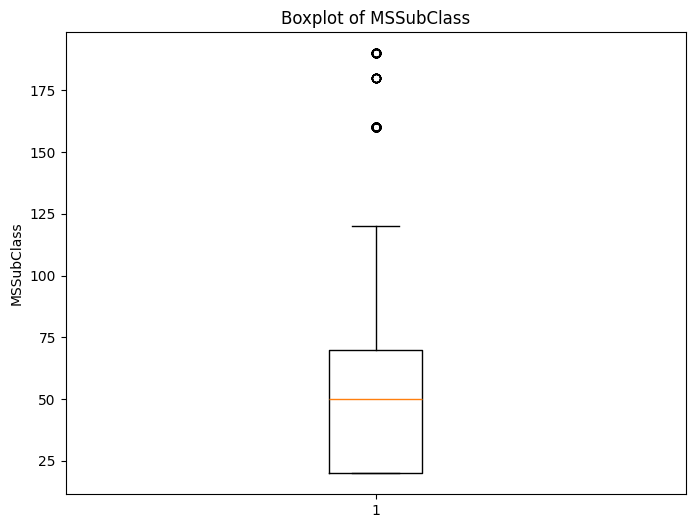

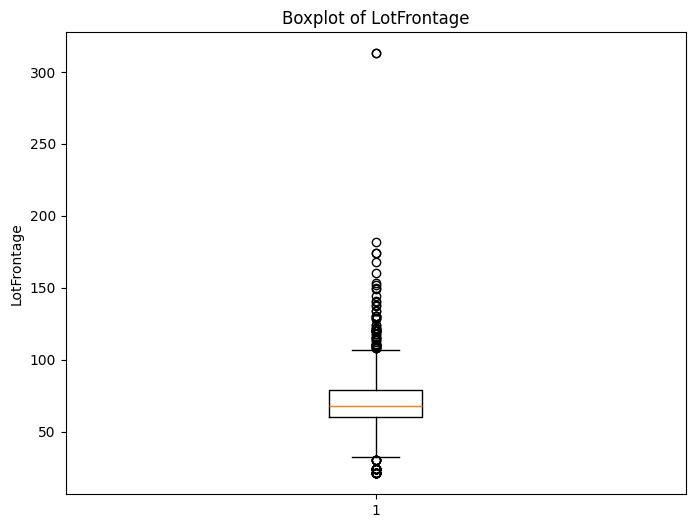

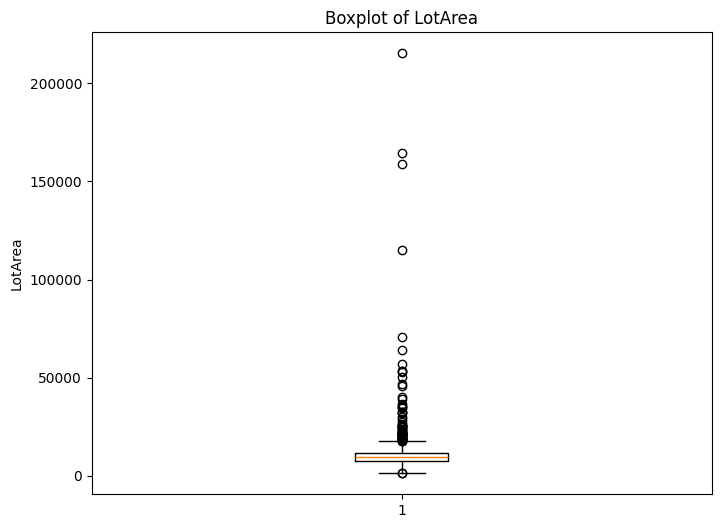

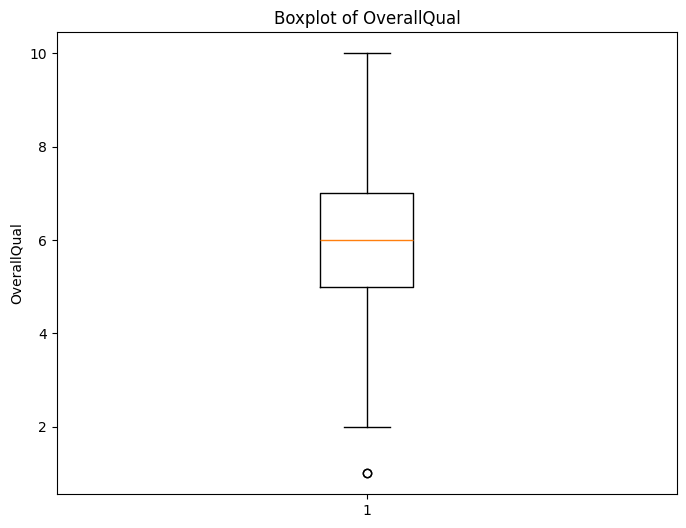

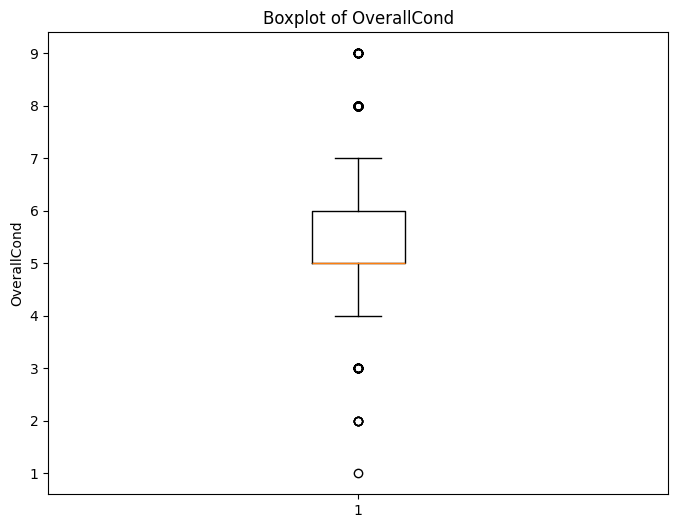

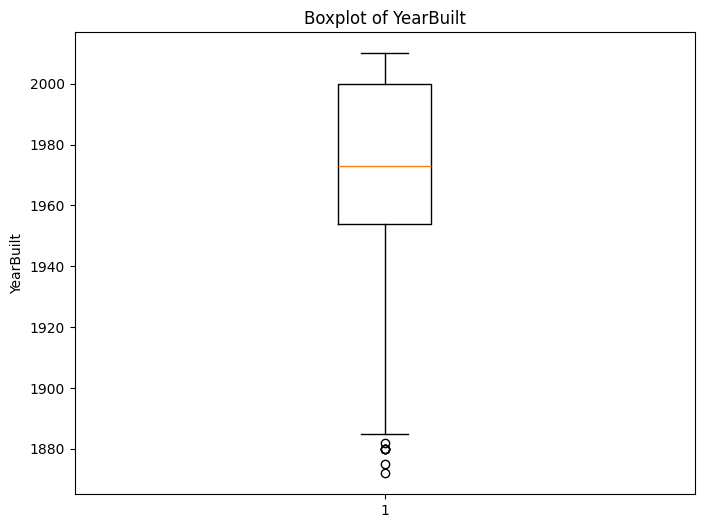

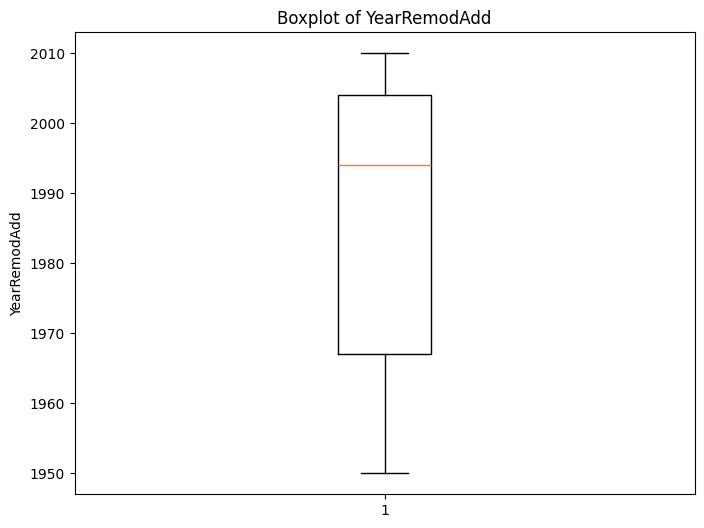

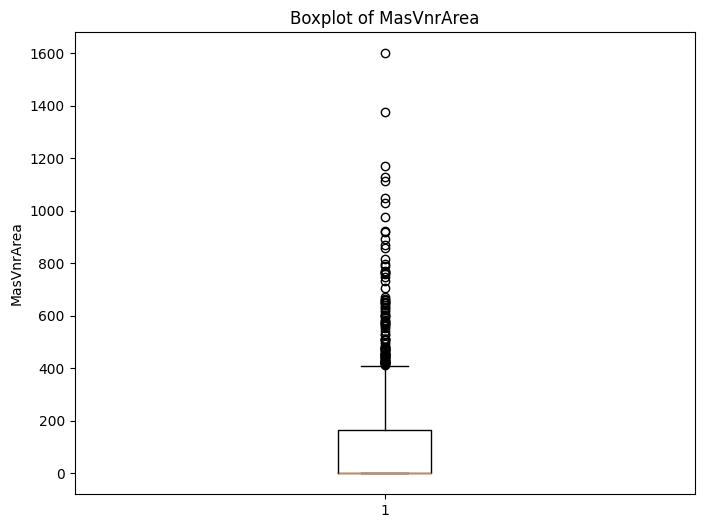

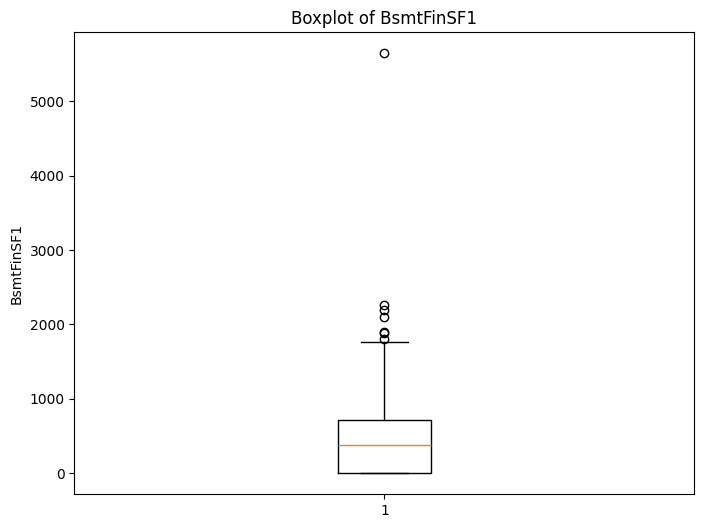

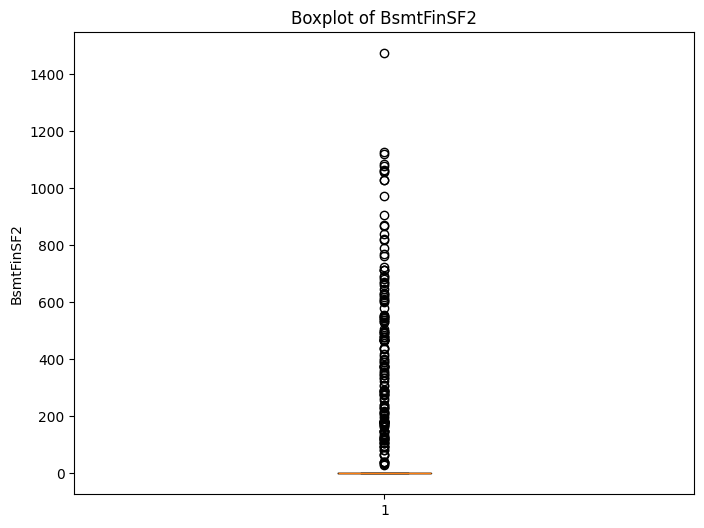

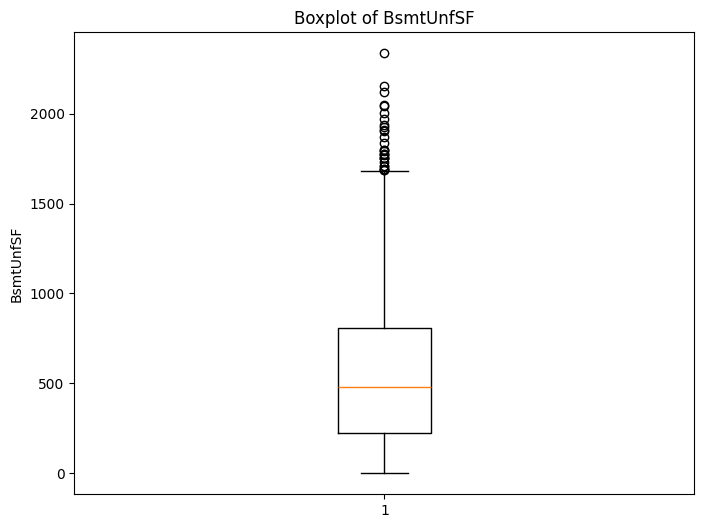

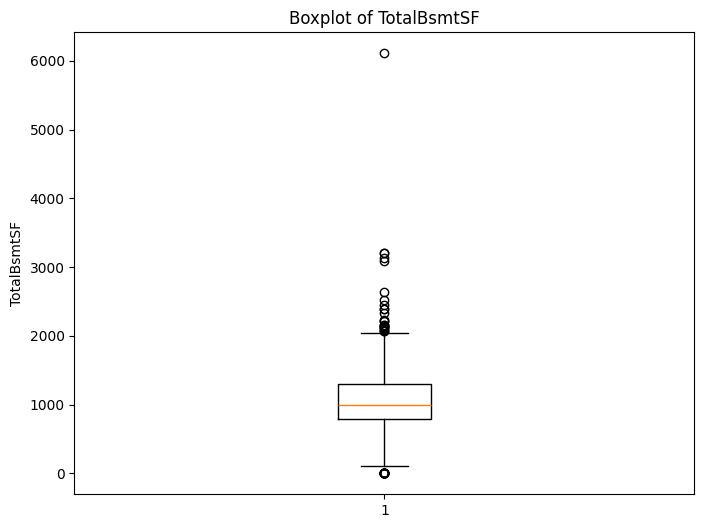

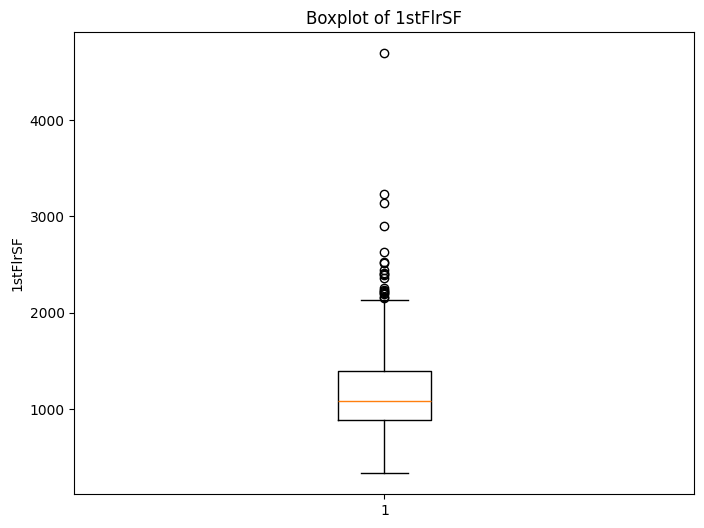

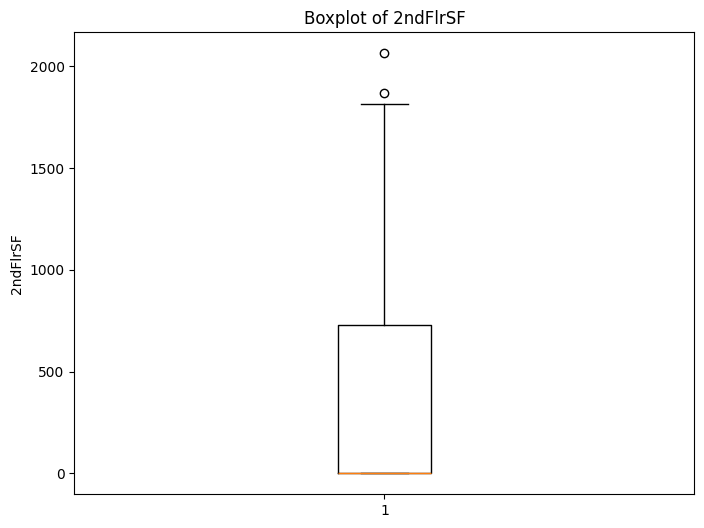

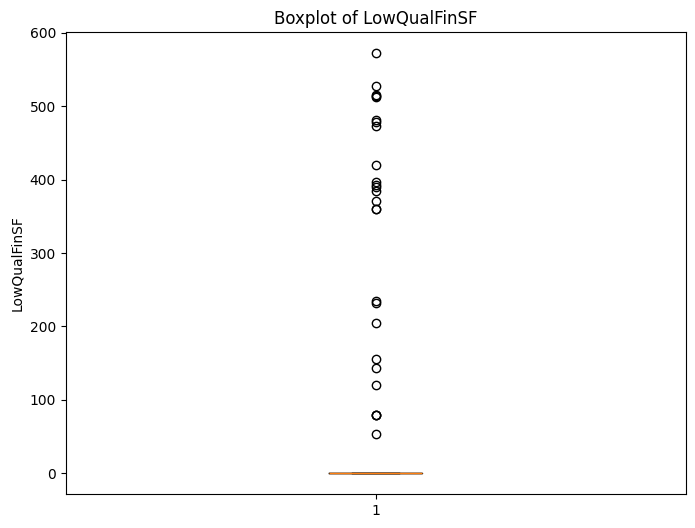

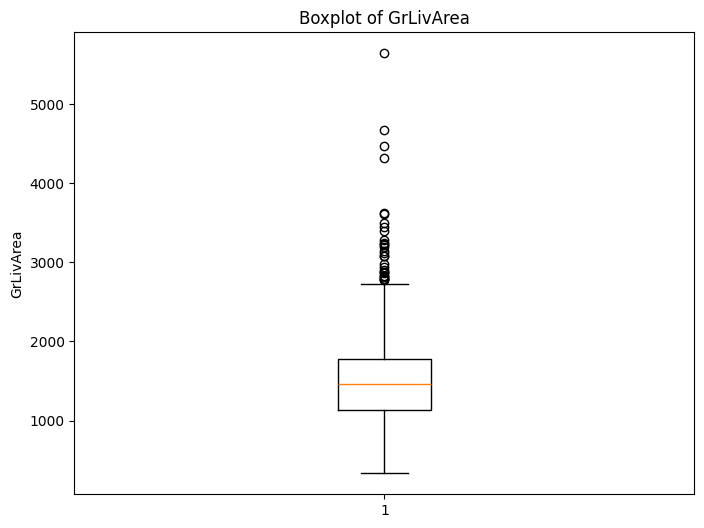

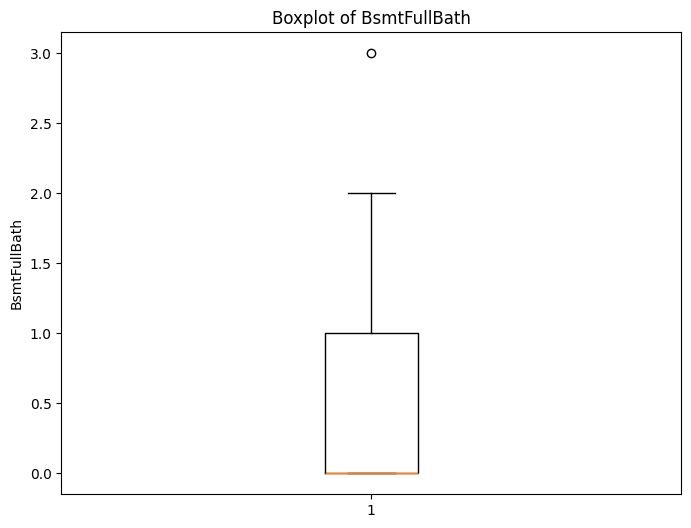

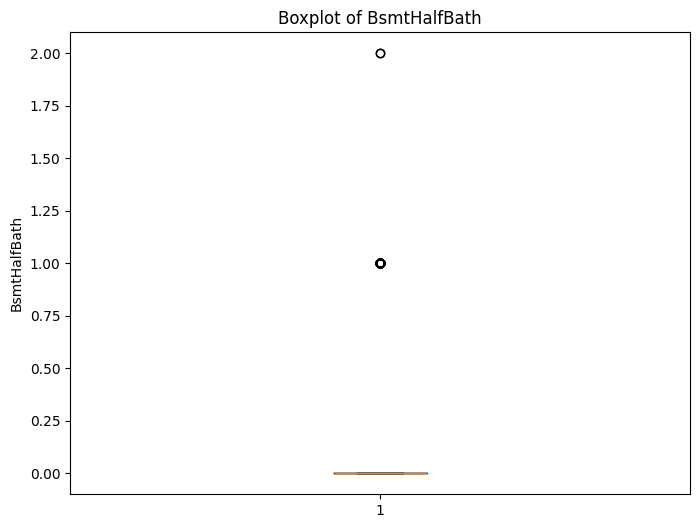

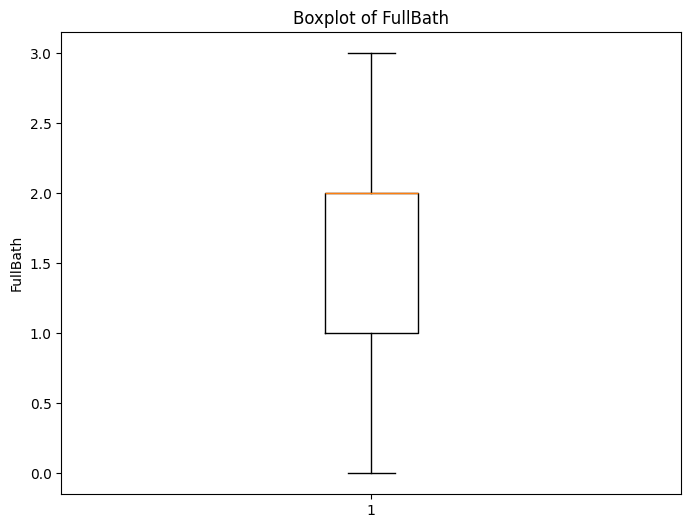

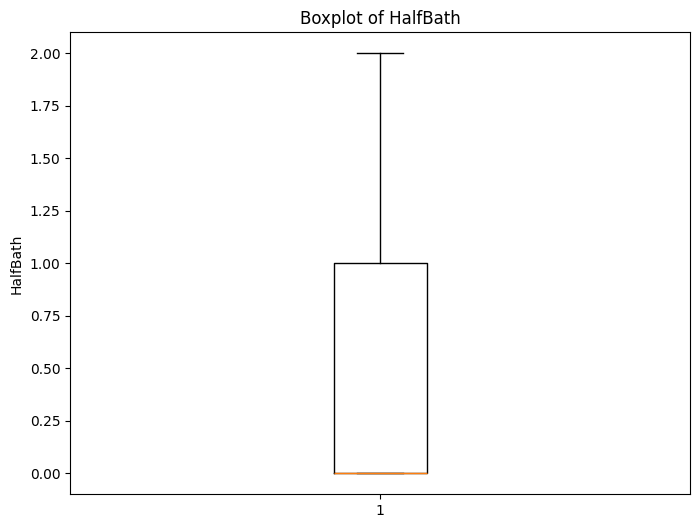

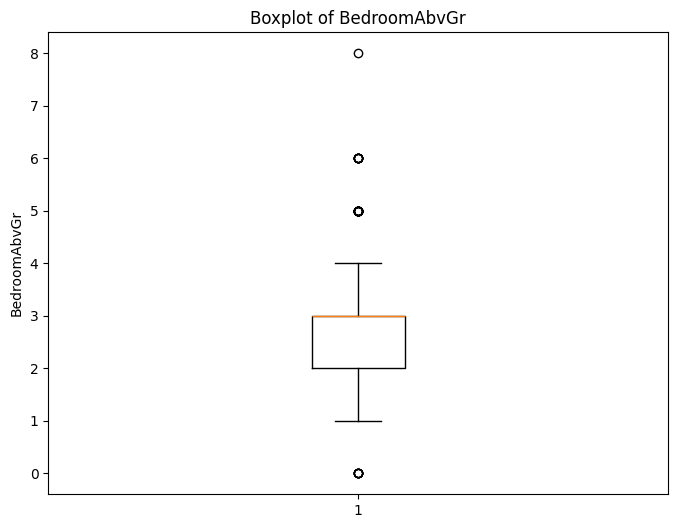

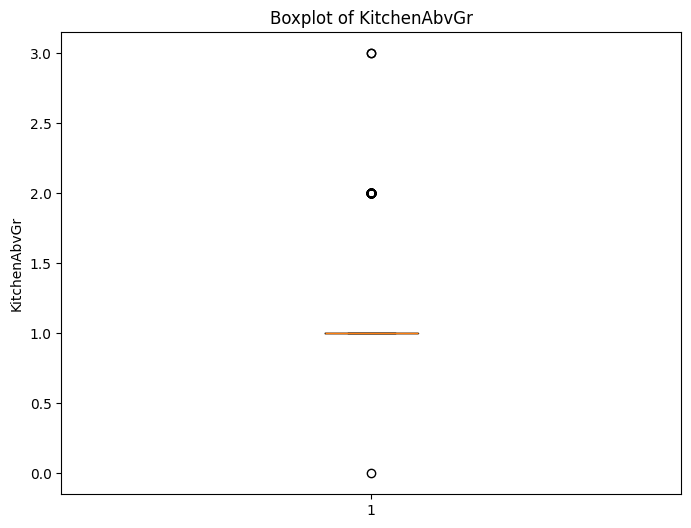

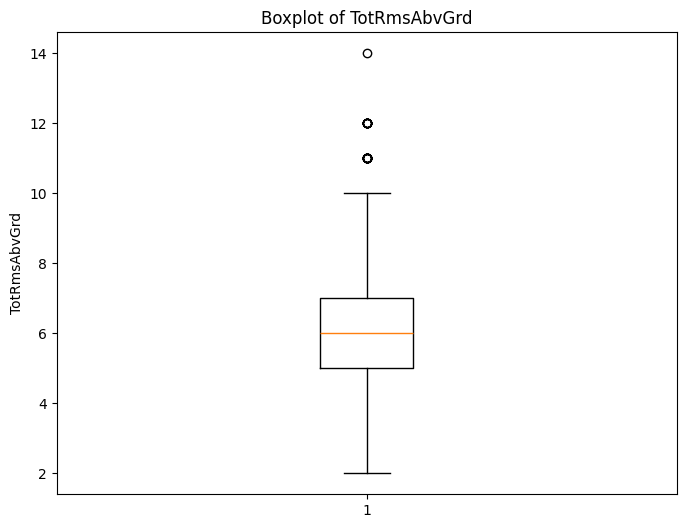

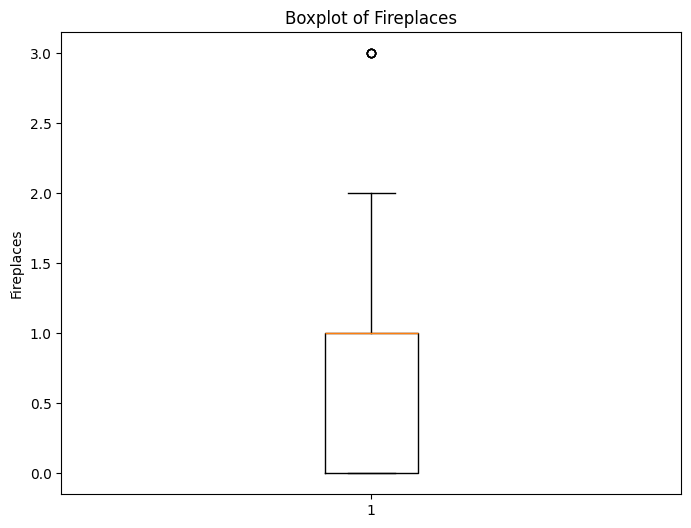

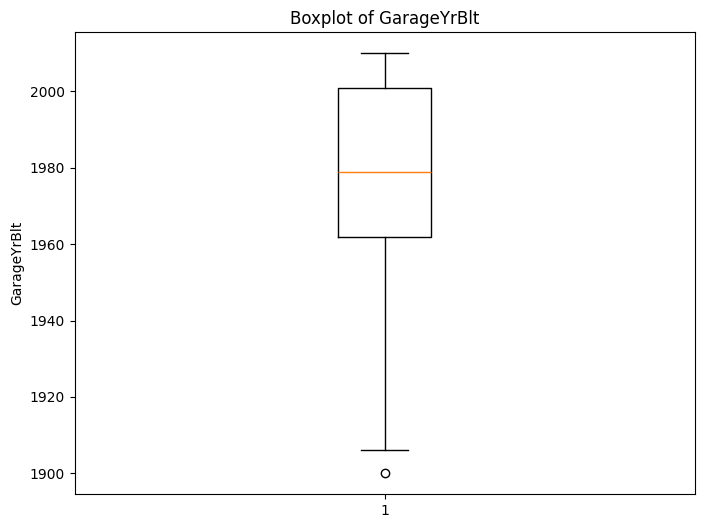

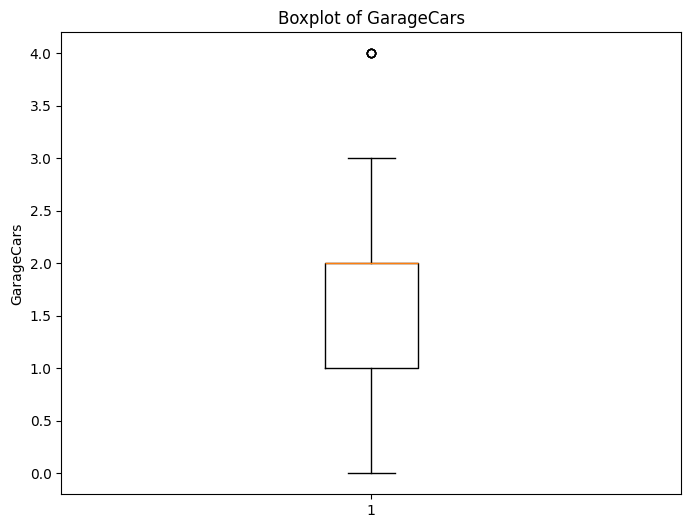

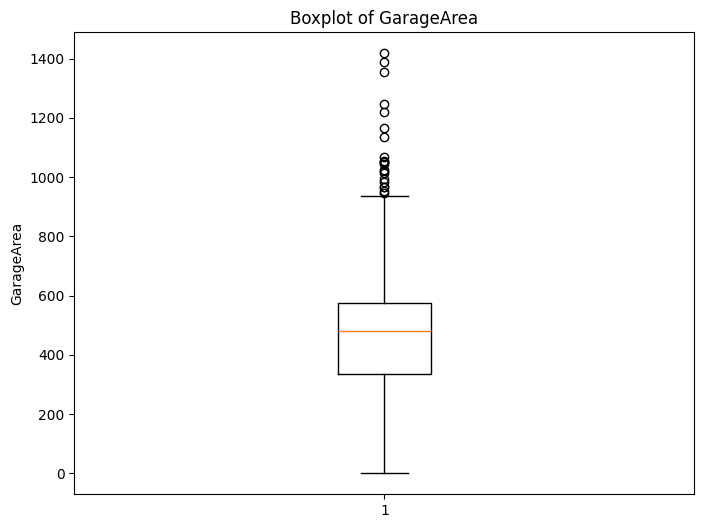

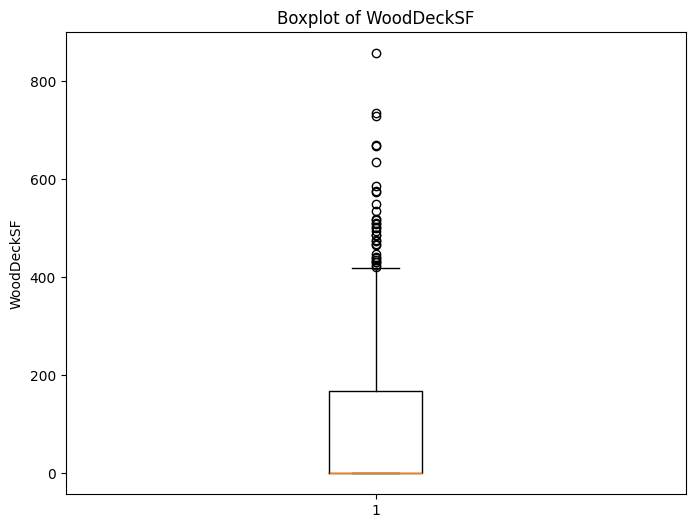

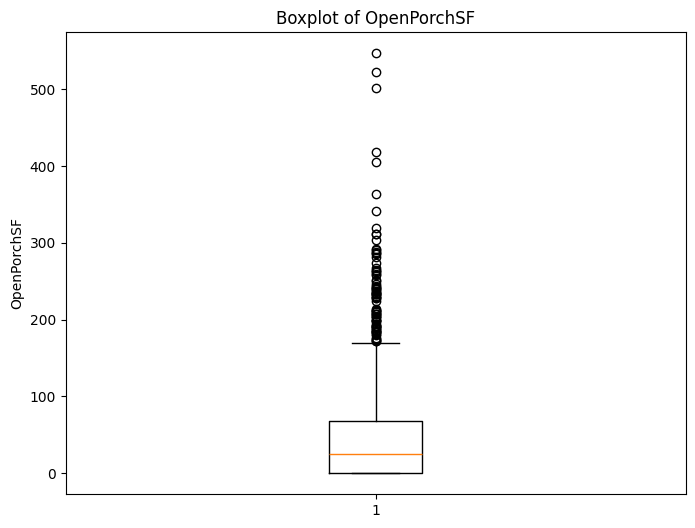

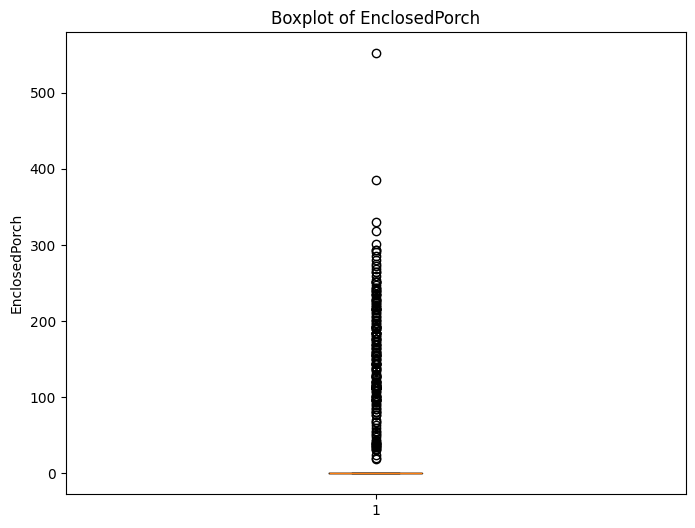

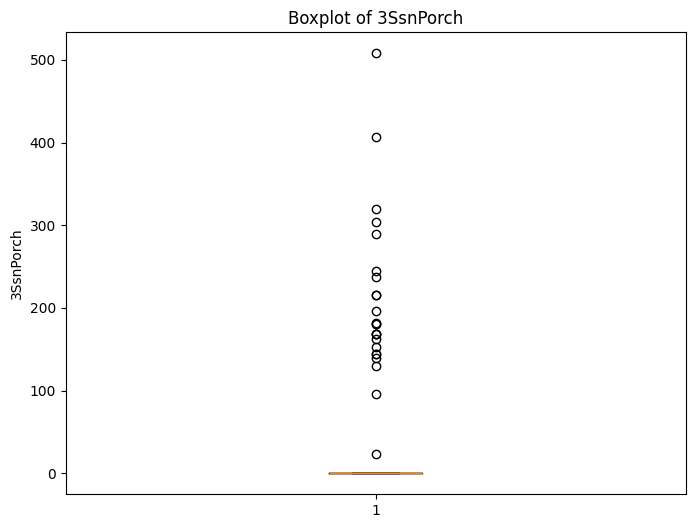

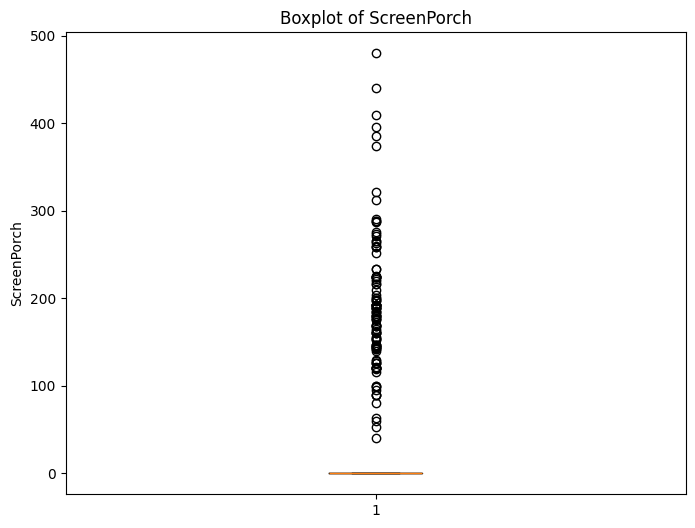

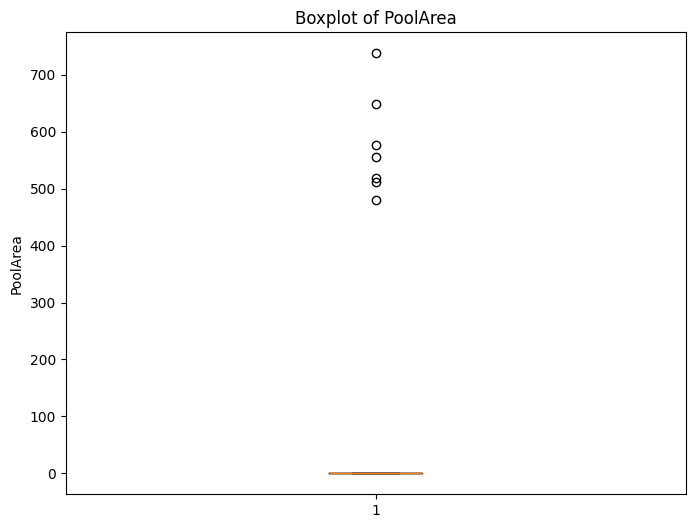

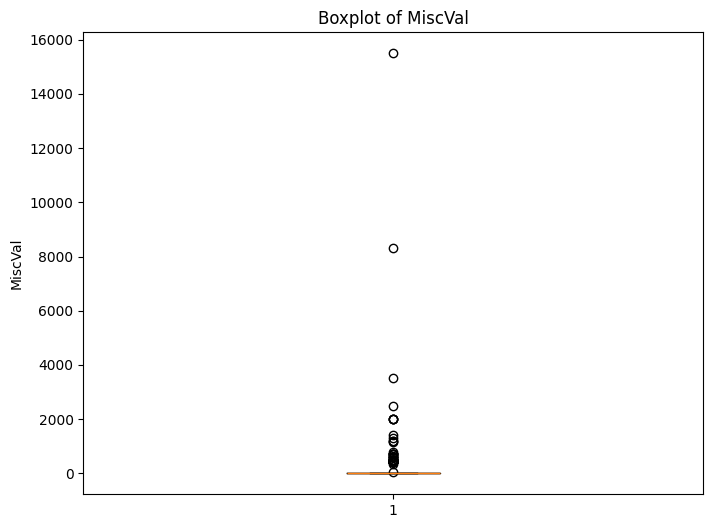

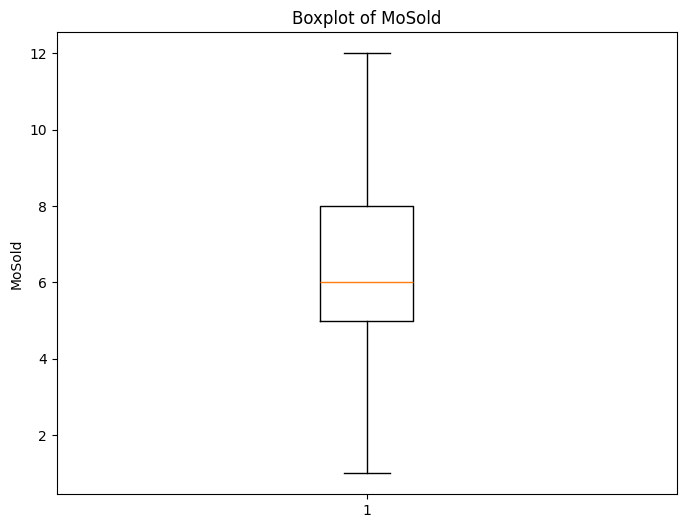

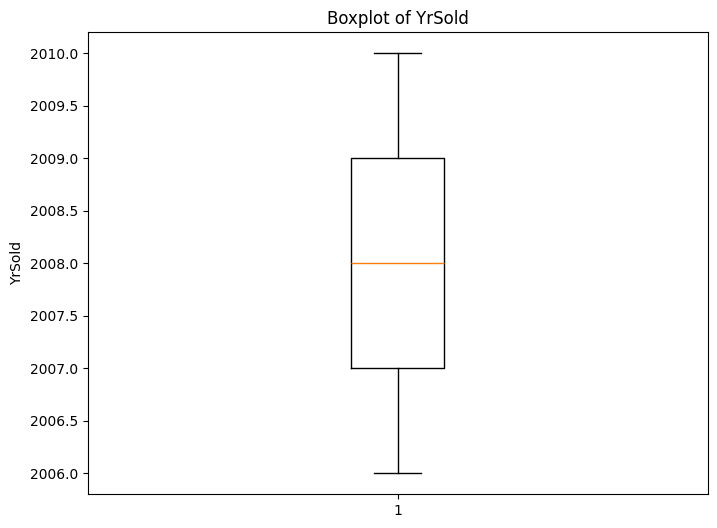

In [6]:
#Check for outliers
for column in numeric_features_all:
  # Supongamos que tienes un DataFrame df y quieres la columna 'SalePrice'
  plt.figure(figsize=(8,6))
  plt.boxplot(X[column])
  plt.title(f'Boxplot of {column}')
  plt.ylabel(column)
  plt.show()



In [23]:
cols_log_all=['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',  'LowQualFinSF', 'GrLivArea', 'GarageArea',
                 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
                        ]

In [86]:
def create_linear_pipeline(numeric_features, categorical_features=None, encoding="label",
                           model_type="linear", alpha=0.01, l1_ratio=0.5, cols_log=None):
    """
    Create a linear, Lasso, Ridge, or ElasticNet regression pipeline with preprocessing.

    Parameters:
    -----------
    numeric_features: list of numeric columns
    categorical_features: list of categorical columns
    encoding: 'label' or 'onehot'
    model_type: 'linear', 'lasso', 'ridge', 'elasticnet'
    alpha: regularization strength (for lasso, ridge, elasticnet)
    l1_ratio: l1 ratio (only for elasticnet)
    cols_log: list of numeric columns to apply log1p transform
    """
    numeric_transformers = []

    # Columns with log transform
    if cols_log is not None and len(cols_log) > 0:
        log_transformer = Pipeline([
            ('log', FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=False)),
            ('scaler', StandardScaler())
        ])
        numeric_transformers.append(('log', log_transformer, cols_log))

        remaining_cols = [col for col in numeric_features if col not in cols_log]
        if len(remaining_cols) > 0:
            numeric_transformers.append(('num', Pipeline([('scaler', StandardScaler())]), remaining_cols))
    else:
        numeric_transformers.append(('num', Pipeline([('scaler', StandardScaler())]), numeric_features))

    transformers = numeric_transformers

    # Categorical transformer
    if categorical_features and len(categorical_features) > 0:
        if encoding == "label":
            categorical_transformer = Pipeline([
                ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
            ])
        elif encoding == "onehot":
            categorical_transformer = Pipeline([
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        else:
            raise ValueError("encoding must be 'label' or 'onehot'")
        transformers.append(('cat', categorical_transformer, categorical_features))

    preprocessor = ColumnTransformer(transformers=transformers)

    # Choose regressor
    if model_type == "linear":
        regressor = LinearRegression()
    elif model_type == "lasso":
        regressor = Lasso(alpha=alpha, random_state=0)
    elif model_type == "ridge":
        regressor = Ridge(alpha=alpha, random_state=0)
    elif model_type == "elasticnet":
        regressor = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=0)
    else:
        raise ValueError("model_type must be 'linear', 'lasso', 'ridge', or 'elasticnet'")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    return pipeline




Let's evaluate six models using linear regression, lasso and ridge. We include some logaritmic scales on the columns where we consider that tere are more outliers.

In [108]:
########### Function to evaluate linear, ridge and lasso models using onehot and label encoding ##############
def evaluate_all_linear(X, y, alpha=0.001, l1_ratio=0.5):
    """
    Evaluates Linear, Lasso, Ridge, and ElasticNet models
    using both label and onehot encoding.

    alpha: regularization strength for Lasso, Ridge, ElasticNet
    l1_ratio: proportion of L1 in ElasticNet (0 = Ridge, 1 = Lasso)
    """
    # Filter columns that exist in X
    num_features = [col for col in numeric_features_all if col in X.columns]
    cat_features = [col for col in categorical_features_all if col in X.columns]
    cols_log = [col for col in cols_log_all if col in X.columns]

    # ---------------- Linear ----------------
    linear_label = create_linear_pipeline(num_features, cat_features, encoding='label', model_type='linear', cols_log=cols_log)
    linear_label_mae, linear_label_rmsle = evaluate_model(X, y, linear_label, return_trained_model=False)

    linear_onehot = create_linear_pipeline(num_features, cat_features, encoding='onehot', model_type='linear', cols_log=cols_log)
    linear_onehot_mae, linear_onehot_rmsle = evaluate_model(X, y, linear_onehot, return_trained_model=False)

    # ---------------- Lasso ----------------
    lasso_label = create_linear_pipeline(num_features, cat_features, encoding='label', model_type='lasso', alpha=alpha, cols_log=cols_log)
    lasso_label_mae, lasso_label_rmsle = evaluate_model(X, y, lasso_label, return_trained_model=False)

    lasso_onehot = create_linear_pipeline(num_features, cat_features, encoding='onehot', model_type='lasso', alpha=alpha, cols_log=cols_log)
    lasso_onehot_mae, lasso_onehot_rmsle = evaluate_model(X, y, lasso_onehot, return_trained_model=False)

    # ---------------- Ridge ----------------
    ridge_label = create_linear_pipeline(num_features, cat_features, encoding='label', model_type='ridge', alpha=alpha, cols_log=cols_log)
    ridge_label_mae, ridge_label_rmsle = evaluate_model(X, y, ridge_label, return_trained_model=False)

    ridge_onehot = create_linear_pipeline(num_features, cat_features, encoding='onehot', model_type='ridge', alpha=alpha, cols_log=cols_log)
    ridge_onehot_mae, ridge_onehot_rmsle = evaluate_model(X, y, ridge_onehot, return_trained_model=False)

    # ---------------- ElasticNet ----------------
    en_label = create_linear_pipeline(num_features, cat_features, encoding='label', model_type='elasticnet', alpha=alpha, l1_ratio=l1_ratio, cols_log=cols_log)
    en_label_mae, en_label_rmsle = evaluate_model(X, y, en_label, return_trained_model=False)

    en_onehot = create_linear_pipeline(num_features, cat_features, encoding='onehot', model_type='elasticnet', alpha=alpha, l1_ratio=l1_ratio, cols_log=cols_log)
    en_onehot_mae, en_onehot_rmsle = evaluate_model(X, y, en_onehot, return_trained_model=False)

    # ---------------- Print results ----------------
    print(f'Linear label encoding:      MAE: {linear_label_mae} | RMSLE: {linear_label_rmsle}')
    print(f'Linear onehot encoding:     MAE: {linear_onehot_mae} | RMSLE: {linear_onehot_rmsle}')
    print(f'Lasso label encoding:       MAE: {lasso_label_mae}  | RMSLE: {lasso_label_rmsle}')
    print(f'Lasso onehot encoding:      MAE: {lasso_onehot_mae} | RMSLE: {lasso_onehot_rmsle}')
    print(f'Ridge label encoding:       MAE: {ridge_label_mae}  | RMSLE: {ridge_label_rmsle}')
    print(f'Ridge onehot encoding:      MAE: {ridge_onehot_mae} | RMSLE: {ridge_onehot_rmsle}')
    print(f'ElasticNet label encoding:  MAE: {en_label_mae}  | RMSLE: {en_label_rmsle}')
    print(f'ElasticNet onehot encoding: MAE: {en_onehot_mae} | RMSLE: {en_onehot_rmsle}')


Lets see how is the performance of the models when changing the alpha value.

In [109]:
alphas =[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]
for alpha in alphas:
  print(f'alpha = {alpha}')
  evaluate_all_linear(X ,y, alpha=alpha)
  print()

alpha = 0.0001
Linear label encoding:      MAE: 16554.932148956806 | RMSLE: 0.13499902820373072
Linear onehot encoding:     MAE: 15994.147899546775 | RMSLE: 0.13370129355799515
Lasso label encoding:       MAE: 16501.26605056856  | RMSLE: 0.13460998156556991
Lasso onehot encoding:      MAE: 15738.567813232523 | RMSLE: 0.13158290424741348
Ridge label encoding:       MAE: 16554.92782911253  | RMSLE: 0.13499899485396077
Ridge onehot encoding:      MAE: 15994.124232444341 | RMSLE: 0.1337010475854373
ElasticNet label encoding:  MAE: 16519.32261363267  | RMSLE: 0.13474507133608907
ElasticNet onehot encoding: MAE: 15819.796807641424 | RMSLE: 0.13227379164745365

alpha = 0.001
Linear label encoding:      MAE: 16554.932148956806 | RMSLE: 0.13499902820373072
Linear onehot encoding:     MAE: 15994.147899546775 | RMSLE: 0.13370129355799515
Lasso label encoding:       MAE: 16358.373401238692  | RMSLE: 0.13368705375045958
Lasso onehot encoding:      MAE: 15501.451617108449 | RMSLE: 0.1295657914818159

We see that the best of the six linear models is Lasso with one-hot encoding woth alpha=0.001. This is expected, as Lasso performs feature selection. In the following sections, we will analyze the coefficients of the model to identify important features and attempt to improve performance. For this purpose, we will define and train an ElasticNet model:.

In [92]:
elastic_onehot = create_linear_pipeline(
    numeric_features_all,
    categorical_features_all,
    encoding='onehot',
    model_type='elasticnet',
    alpha=0.001,
    l1_ratio=0.5,
    cols_log=cols_log_all
)

In [94]:
# Save only the trained pipeline
_, _, elastic_onehot = evaluate_model(X, y, elastic_onehot, return_trained_model=True)

## XGBoost model
Now let's train an XGBoost model baseline. We use X_label which alredy encoded the categorical feature.

In [104]:
xgb_model = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae, xgb_rmsle , xgb_model = evaluate_model(X_label,y, xgb_model)


In [13]:
print(f'XGB_model:      MAE: {xgb_mae}     |      RMSLE:  {xgb_rmsle}')

XGB_model:      MAE: 16455.4765625     |      RMSLE:  0.1373682430001371


## Feature Selection

Let's use varios inspection methods to decide which features are more important. We can
* Check the coeficients of our Lasso regression models.
* Use the XGBoost gain to help us to select features.
* Use mutual information of the features and the target.

### Linear regression coeficients

In [84]:
###################### Extract and plot coefficients for Linear Regression model ###########

### Extract coeficients by order of absolute value
def get_coef_signed(lreg_pipeline):
    """
    Extract names of features and coeficients of a linear pipeline.
    """
    preprocessor = lreg_pipeline.named_steps['preprocessor']
    regressor = lreg_pipeline.named_steps['regressor']

    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if hasattr(transformer, 'named_steps'):  # Pipeline
            encoder = list(transformer.named_steps.values())[0]
        else:
            encoder = transformer

        if hasattr(encoder, 'get_feature_names_out'):
            feature_names.extend(encoder.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': regressor.coef_.ravel()
    })

    # Sort by absolute value
    coef_df = coef_df.sort_values(by='coefficient', key=abs, ascending=False).reset_index(drop=True)

    return coef_df



# Plot top coeficients
def plot_coeficients_importance(coef_df, top_n=20, title="Feature Importances"):
    """
    Plot the coefficients from get_coef_simple output.

    Parameters:
    -----------
    coef_df : pd.DataFrame
        Output from get_coef_simple (must have 'feature' and 'coefficient').
    top_n : int, optional
        Number of top features to plot (default=20).
    title : str, optional
        Plot title.
    """
    # Select top_n by absolute value
    coef_df_sorted = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)
    coef_df_top = coef_df_sorted.head(top_n)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(coef_df_top['feature'], coef_df_top['coefficient'], color="skyblue")
    plt.axvline(0, color='k', linestyle='--')
    plt.title(title)
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # biggest on top

    # Color positive/negative
    for bar, val in zip(bars, coef_df_top['coefficient']):
        if val < 0:
            bar.set_color('salmon')

    plt.show()





Let's get and plot the coeficients for lasso onehot.

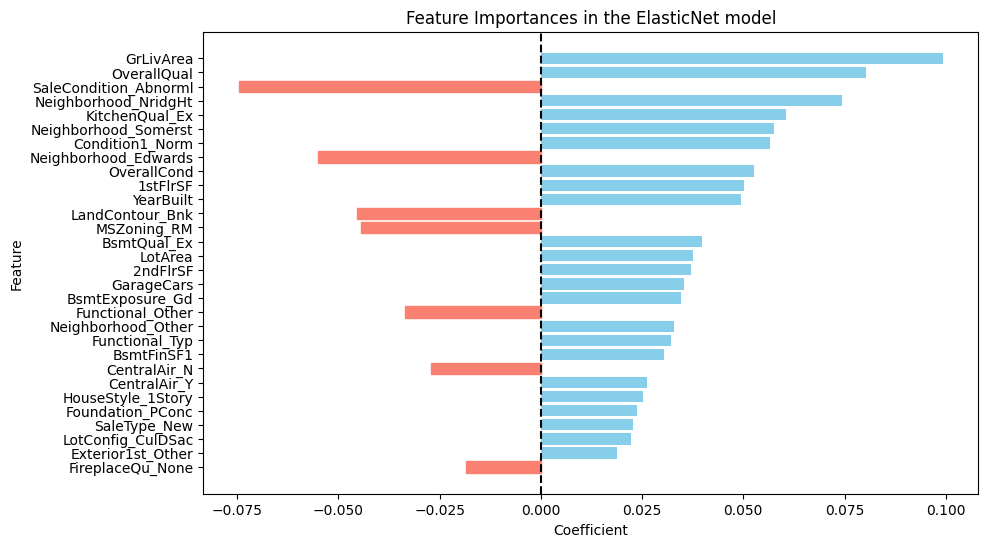

In [97]:
elastic_coef = get_coef_signed(elastic_onehot)
plot_coeficients_importance(elastic_coef, top_n=30, title="Feature Importances in the ElasticNet model")

In [99]:
positive_coeficients = elastic_coef[elastic_coef.coefficient>0]
elastic_features = list({cat.split('_')[0] for cat in positive_coeficients.feature.tolist()} )
X_elastic = X[elastic_features]
X_elastic.shape

(1460, 45)

Selecting features using the Elastic coeficient gives us a list of 45 features. Let's see how our models perform with these features in diferent values of alpha.

In [111]:
print('################ Restricting to the Elastic features #####################\n')

alphas =[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100]
for alpha in alphas:
  print(f'alpha = {alpha}')
  evaluate_all_linear(X_elastic ,y, alpha=alpha)
  print()

################ Restricting to the Elastic features #####################

alpha = 0.0001
Linear label encoding:      MAE: 16513.158618901325 | RMSLE: 0.13437912881142255
Linear onehot encoding:     MAE: 15653.080273576647 | RMSLE: 0.1304235601905832
Lasso label encoding:       MAE: 16506.750166291284  | RMSLE: 0.13431650621965932
Lasso onehot encoding:      MAE: 15576.297257990507 | RMSLE: 0.13003046680815028
Ridge label encoding:       MAE: 16513.158164901186  | RMSLE: 0.13437912353220152
Ridge onehot encoding:      MAE: 15653.077525061912 | RMSLE: 0.13042354335007
ElasticNet label encoding:  MAE: 16509.391293536057  | RMSLE: 0.1343420555322737
ElasticNet onehot encoding: MAE: 15609.853402150382 | RMSLE: 0.13020073460674378

alpha = 0.001
Linear label encoding:      MAE: 16513.158618901325 | RMSLE: 0.13437912881142255
Linear onehot encoding:     MAE: 15653.080273576647 | RMSLE: 0.1304235601905832
Lasso label encoding:       MAE: 16532.4173478992  | RMSLE: 0.13440920833799075
Lasso o

We observe that when restricting our models to the variables selected by elasticNet, there is a slight improvement in the Ridge model with alpha equal to 50. Let's conclude the feature selection with elastic net by evaluating a XGBoost model with these features.

In [113]:
xgb_model_e = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae_e, xgb_rmsle_e , xgb_model_e = evaluate_model(X_label[elastic_features],y, xgb_model_e)

print(f'XGB_model:      MAE: {xgb_mae_e}     |      RMSLE:  {xgb_rmsle_e}')

XGB_model:      MAE: 16508.17578125     |      RMSLE:  0.13555710048162828


We see that the reduction of these features also improves sligghtly the XGBoost model.

### XGBoost gain

In [125]:
# Function to get XGBoost feature importance as DataFrame
def get_xgb_feature_importance_df(XGB_model):
    """
    Return XGBoost feature importance as a DataFrame sorted by gain.

    Parameters:
    -----------
    XGB_model : trained XGBRegressor or XGBClassifier
        Trained XGBoost model
    top_n : int
        Number of top features to return

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['feature', 'gain'] sorted by gain descending
    """
    importance_dict = XGB_model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'gain': list(importance_dict.values())
    }).sort_values(by='gain', ascending=False).reset_index(drop=True)

    return importance_df

# Function to plot XGBoost feature importance from a DataFrame
def plot_xgb_feature_importance(importance_df):
    """
    Plot XGBoost feature importance from a DataFrame.

    Parameters:
    -----------
    importance_df : pd.DataFrame
        DataFrame with columns ['feature', 'gain']
    """
    plt.figure(figsize=(10, max(6, 0.3*len(importance_df))))
    plt.barh(importance_df['feature'], importance_df['gain'], color='skyblue')
    plt.gca().invert_yaxis()  # largest gain at top
    plt.xlabel('Gain')
    plt.title(f'Top {len(importance_df)} XGBoost Features by Gain')
    plt.show()




In [128]:
# Obtener el DataFrame de importancia
xgb_importance_df = get_xgb_feature_importance_df(xgb_model)
xgb_importance_df


,feature,gain
0,OverallQual,1.082320
1,CentralAir,0.343341
2,GarageCars,0.324384
3,KitchenAbvGr,0.154908
4,GrLivArea,0.080168
...,...,...
64,MasVnrType,0.002250
65,RoofStyle,0.001976
66,MiscVal,0.001956
67,YrSold,0.001917


In [135]:
xgb_features_ordered =  xgb_importance_df.feature.tolist()
sizes = [10, 20, 30, 35, 40, 45]
features_lists = [xgb_features_ordered[: end] for end in sizes]

for cols in features_lists:
  print('size:', len(cols))
  evaluate_all_linear(X[cols] ,y)
  print()


size: 10
Linear label encoding:      MAE: 22571.348075060512 | RMSLE: 0.17110810025229936
Linear onehot encoding:     MAE: 22487.78800991598 | RMSLE: 0.17023067492858446
Lasso label encoding:       MAE: 22567.280605636064  | RMSLE: 0.17121497071297087
Lasso onehot encoding:      MAE: 22501.162940140166 | RMSLE: 0.1705747643996363
Ridge label encoding:       MAE: 22571.347544952616  | RMSLE: 0.1711080882347948
Ridge onehot encoding:      MAE: 22487.78841167918 | RMSLE: 0.1702306650261911
ElasticNet label encoding:  MAE: 22568.131877903845  | RMSLE: 0.17113732253109457
ElasticNet onehot encoding: MAE: 22488.548940918576 | RMSLE: 0.1703300804417874

size: 20
Linear label encoding:      MAE: 18335.381890212062 | RMSLE: 0.14284872585080124
Linear onehot encoding:     MAE: 17974.010608405784 | RMSLE: 0.1423973442069123
Lasso label encoding:       MAE: 18285.89266984097  | RMSLE: 0.1426378391150396
Lasso onehot encoding:      MAE: 17898.036389786055 | RMSLE: 0.14184092158644443
Ridge label en

In [141]:
xgb_features=xgb_features_ordered[:35]

xgb_model_xgb = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae_xgb, xgb_rmsle_xgb , xgb_model_xgb = evaluate_model(X_label.loc[:,xgb_features],y, xgb_model_xgb)

print(f'XGB_model:      MAE: {xgb_mae_xgb}     |      RMSLE:  {xgb_rmsle_xgb}')

XGB_model:      MAE: 16286.9423828125     |      RMSLE:  0.13571463946056825


### Mutual information

In [144]:

from sklearn.feature_selection import mutual_info_regression

# --- Function to compute MI scores ---
def get_mi_scores(X, y, discrete_features=None, top_n=None):
    """
    Compute mutual information (MI) scores for features in X against y.

    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series or array-like
        Target vector
    discrete_features : list or boolean array, optional
        Specify which features are discrete/categorical
    top_n : int, optional
        If specified, return only the top_n features with highest MI

    Returns:
    --------
    pd.Series
        MI scores sorted descending
    """
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, index=X.columns, name='MI Scores')
    mi_scores = mi_scores.sort_values(ascending=False)
    if top_n is not None:
        mi_scores = mi_scores.iloc[:top_n]
    return mi_scores


# --- Function to plot MI scores ---
def plot_mi_scores(mi_scores, top_n=None):
    """
    Plot mutual information (MI) scores from a Series.

    Parameters:
    -----------
    mi_scores : pd.Series
        Series with MI scores indexed by feature names
    top_n : int, optional
        If specified, plot only the top_n features
    """
    if top_n is not None:
        mi_scores = mi_scores.iloc[:top_n]

    plt.figure(figsize=(10, max(4, 0.3*len(mi_scores))))
    mi_scores.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.xlabel('Mutual Information')
    plt.title('Feature Importance via Mutual Information')
    plt.show()


In [148]:
# Obtener MI scores
mi_scores = get_mi_scores(X_label, y, discrete_features=[col in categorical_features for col in X_label.columns])

mi_scores

,MI Scores
OverallQual,0.571604
GrLivArea,0.482620
GarageCars,0.371297
TotalBsmtSF,0.368014
GarageArea,0.366591
...,...
LowQualFinSF,0.000000
MiscVal,0.000000
PoolArea,0.000000
YrSold,0.000000


In [153]:
mi_features = mi_scores[mi_scores>0].index.tolist()
X_mi = X[mi_features]

In [160]:
mi_elastic_features = list(set(mi_features)&set(elastic_features))

In [161]:
print('################ Restricting to the mi features #####################\n')

alphas =[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100]
for alpha in alphas:
  print(f'alpha = {alpha}')
  evaluate_all_linear(X[mi_elastic_features]  ,y, alpha=alpha)
  print()

################ Restricting to the mi features #####################

alpha = 0.0001
Linear label encoding:      MAE: 16524.75406238956 | RMSLE: 0.13417910384888396
Linear onehot encoding:     MAE: 15953.821496429713 | RMSLE: 0.13182900187005622
Lasso label encoding:       MAE: 16519.146198996346  | RMSLE: 0.13414142723046998
Lasso onehot encoding:      MAE: 15868.138386127002 | RMSLE: 0.13145375846241245
Ridge label encoding:       MAE: 16524.753606710874  | RMSLE: 0.1341790993194025
Ridge onehot encoding:      MAE: 15953.818658801374 | RMSLE: 0.13182898528463446
ElasticNet label encoding:  MAE: 16521.40861134758  | RMSLE: 0.13415658624633237
ElasticNet onehot encoding: MAE: 15906.954134416013 | RMSLE: 0.13161936255649484

alpha = 0.001
Linear label encoding:      MAE: 16524.75406238956 | RMSLE: 0.13417910384888396
Linear onehot encoding:     MAE: 15953.821496429713 | RMSLE: 0.13182900187005622
Lasso label encoding:       MAE: 16544.451591168032  | RMSLE: 0.13435082325244962
Lasso on

In [163]:


xgb_model_mi = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

xgb_mae_mi, xgb_rmsle_mi , xgb_model_mi = evaluate_model(X_label.loc[:,mi_features],y, xgb_model_mi)

print(f'XGB_model:      MAE: {xgb_mae_mi}     |      RMSLE:  {xgb_rmsle_mi}')

XGB_model:      MAE: 16756.869140625     |      RMSLE:  0.13769843744509355


#Best model and submit generator

In [121]:
cols = elastic_features
numeric_features = [col for col in numeric_features_all if col in X[cols].columns]
categorical_features = [col for col in categorical_features_all if col in X[cols].columns]
cols_log = [col for col in cols_log_all if col in X[cols].columns]

best_model = create_linear_pipeline(numeric_features, categorical_features, encoding="onehot",
                           model_type="ridge", alpha=50, cols_log=cols_log)
MAE, LMSE, best_model = evaluate_model(X[cols], y, best_model, return_trained_model=True)
MAE, LMSE

(15625.044723857683, np.float64(0.12905239396073928))

In [122]:
import pandas as pd
import numpy as np

# 1️⃣ Load preprocessed test set and raw test set
X_test = pd.read_csv("test_pre.csv")       # preprocessed features
df_test_raw = pd.read_csv("test_raw.csv")  # original file with Ids

# 2️⃣ Predict using trained model
# If your model was trained with log1p(SalePrice)
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # revert log1p transformation

# 3️⃣ Create submission DataFrame
submission = pd.DataFrame({
    "Id": df_test_raw["Id"],  # use Id from original file
    "SalePrice": y_pred
})

# 4️⃣ Save submission CSV
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")



Submission file created: submission.csv
